In [444]:
#https://www.kaggle.com/c/tmdb-box-office-prediction/data

In [445]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [446]:
train = pd.read_csv('tmdb-box-office-prediction/train.csv')
test = pd.read_csv('tmdb-box-office-prediction/test.csv')

In [447]:
train['dataset'] = 'train'
test['dataset'] = 'test'

train = train.append(test, sort=False);

train.reset_index(inplace=True, drop=True)

I don't want to repeat any data wrangling twice, I will split the datasets before training the model.

### Exploratory data analysis

First of all, let's get an understanding of our dependent variable

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


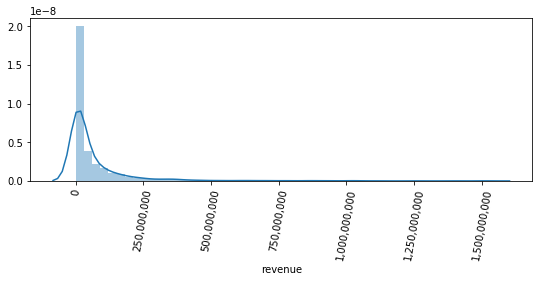

In [448]:
plt.figure(figsize=(9, 3))
g = sns.distplot(train[train.revenue.notnull()]['revenue'])

xlabels = ['{:,.0f}'.format(x)  for x in g.get_xticks()/1]


g.set_xticklabels(xlabels, rotation=80);

The vast majority are productions with little revenue, with a couple of outliers raking in hundreds of millions

In [449]:
train.sort_values("revenue")[['title', 'revenue', 'release_date']].head(10)

,title,revenue,release_date
347,The Wind in the Willows,1.00,10/16/96
1754,Mute Witness,1.00,9/28/95
1917,The Merry Widow,1.00,8/26/25
1874,Missing,1.00,1/1/07
695,Tere Naam,2.00,8/15/03
334,Saamy,3.00,5/5/03
1541,All at Once,3.00,6/5/14
2383,Borsalino,3.00,5/19/70
2117,American Adobo,4.00,9/29/01
1346,East of Eden,5.00,3/9/55


I'm having doubts about such low revenue values... How can a movie have revenue of 1? <br>
Unless what is meant here is profit, and not revenue?

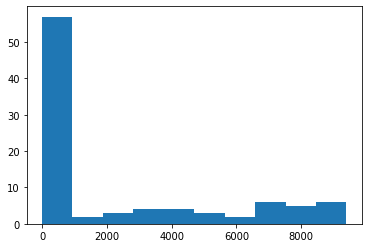

In [450]:
(n, bins, patches) = plt.hist(train[train.revenue < 10000]['revenue'])
plt.ticklabel_format(style='plain')

From the histogram it's visible that plotting the movies with low revenue (less than 10k), the smallest bin
is biggest. <br>This suggests the data was input wrongly (i.e. 12 means 12 thousand). Otherwise we would see
a more-less smooth, continuous distribution. Keeping these data points in, will drive the regression coefficients towards zero, 
acting a bit like an L2 penalty, which prevents overfitting, but in our case it would simply mean wrong predictions. I will drop the values in the smallest bin.

### Problem
If the test data true y labels also have some 0s in them, it will seriously jeopardize accuracy of my predictions.

Let's hone in on the exact cut off point for data with too low (wrong budget)

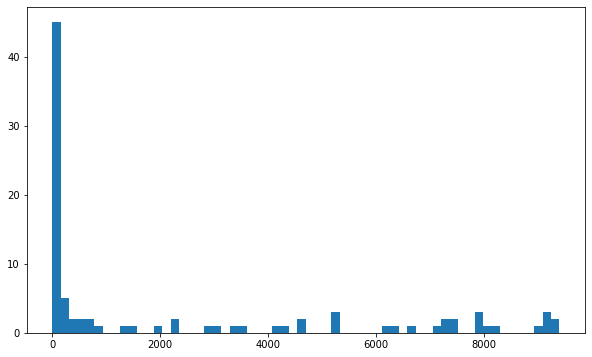

In [451]:
plt.figure(figsize=(10, 6))
(n, bins, patches) = plt.hist(train[train.revenue < 10000]['revenue'], bins=60)
plt.ticklabel_format(style='plain')

In [452]:
bins[1]

157.51666666666668

In [453]:
len(train[train.revenue < bins[1]])

45

In [454]:
train[train.revenue < bins[1]][['budget', 'revenue']]

,budget,revenue
150,0,18.00
269,0,20.00
280,0,10.00
312,16000000,12.00
334,1,3.00
347,12,1.00
450,23000000,12.00
498,0,25.00
579,0,88.00
639,6,8.00


In [455]:
pd.set_option('display.max_rows', 10)
mask1 = train.revenue.notnull()
mask2 = train.revenue < bins[1]
train = train[~ (mask1 & mask2)]

### Language

In [456]:
train['is_english'] = train.original_language == 'en'

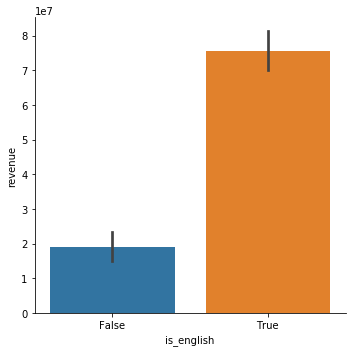

In [457]:
sns.catplot(x="is_english", y='revenue', data=train, kind='bar', );

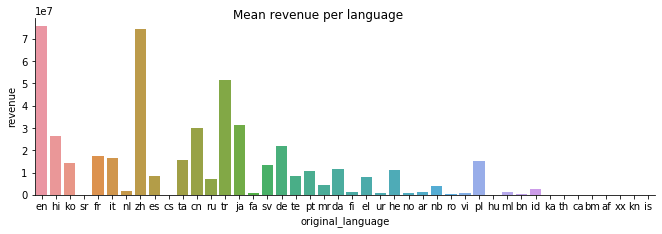

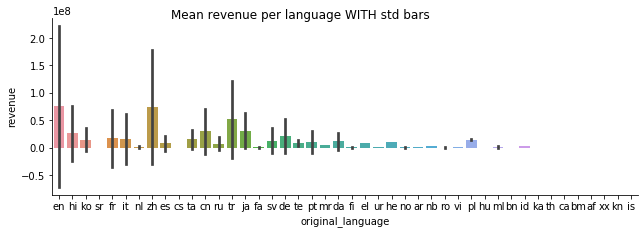

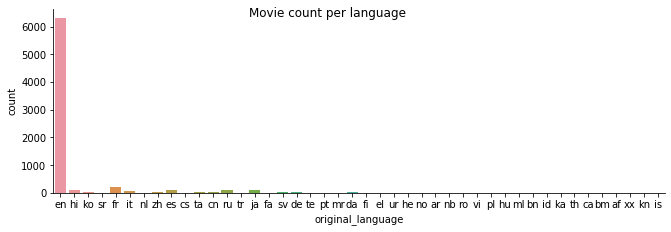

In [458]:
cat = sns.catplot(x="original_language", y='revenue', data=train, kind='bar', ci=None);
cat.fig.set_size_inches(10, 3)
cat.fig.suptitle("Mean revenue per language")

cat = sns.catplot(x="original_language", y='revenue', data=train, kind='bar', ci='sd');
cat.fig.set_size_inches(10, 3)
cat.fig.suptitle("Mean revenue per language WITH std bars")

cat = sns.catplot(x="original_language", data=train, kind='count',ci=None );
cat.fig.set_size_inches(10, 3)
cat.fig.suptitle("Movie count per language");

English language movies bring in most revenue on average, but turkish or chinese ones rank high too.<br>
However, we don't have enough data points for those non-english movies to generalize well.<br>
We also see that the STD is really big. This is because std (just like correlation, which uses std) is sensitive to outliers. (Interquantile range is largely immune to outliers and we can use it instead).<br>

In [459]:
train.original_language.value_counts()[:15]

en    6316
fr     198
hi     116
ru     108
es      95
      ... 
cn      41
ta      30
sv      19
da      17
pt      13
Name: original_language, Length: 15, dtype: int64

In [460]:
langs = list(train.original_language.value_counts()[:15].index)

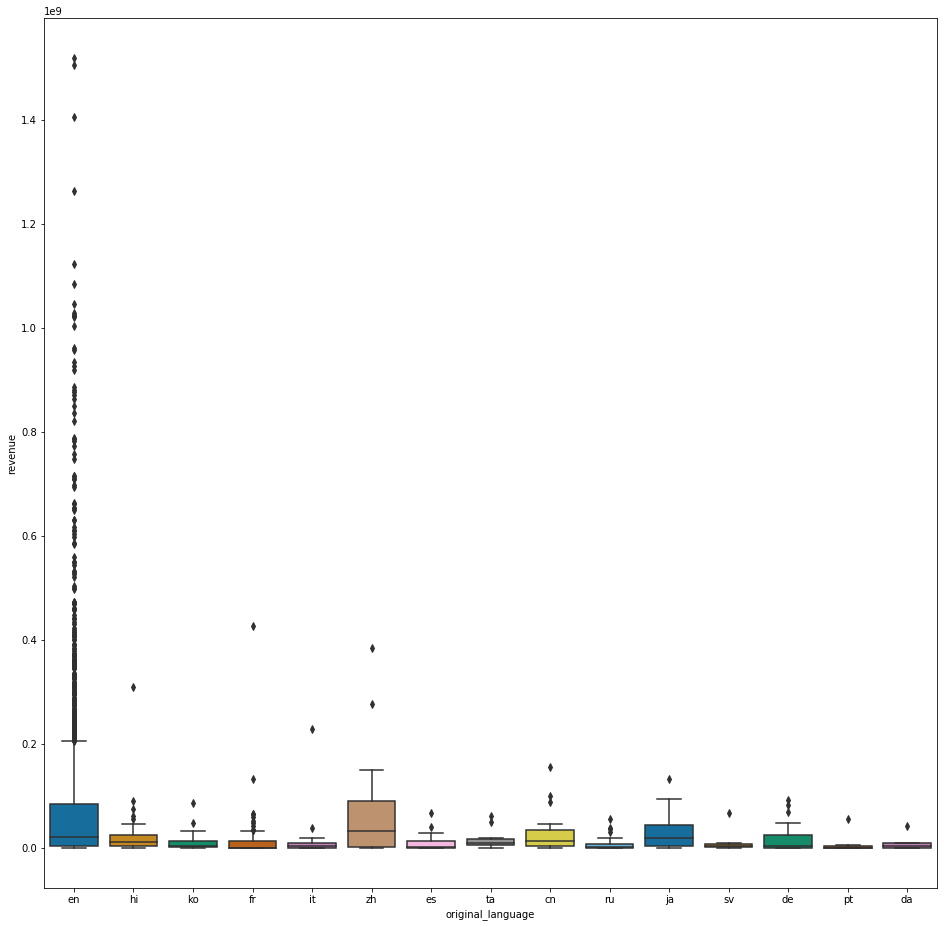

In [461]:
b = sns.boxplot(y='revenue', x='original_language', 
                 data=train[(train.dataset == 'train') & (train.original_language.isin(langs))], 
                 palette="colorblind",
                 )
b.figure.set_size_inches(16, 16)

We see A LOT of outliers. The task won't be easy. Even though english movies have a much higher average revenue than non-english ones, the variance is just huge. It's also way too many of them to delete. I'm no longer so sure it's a good feature.

In [462]:
train.drop('original_language', axis=1, inplace=True)

### Sequels

It could be that sequels fetch less/more money than original movies  as they generally tend to be worse.<br> On the other hand, only movies that perform well, get to have a sequel.
I have a column telling me if a movie belongs to a collection, but it doesn't tell me if it's the first movie, or a subsequent one

In [463]:
train['sequel'] = train.title.str.findall("\s\d$").apply(bool)

In [464]:
train.title = train.title.str.replace("VIII", "8")
train.title = train.title.str.replace("VII", "7")
train.title = train.title.str.replace("VI", "6", case=True)
train.title = train.title.str.replace("\sV", "5")
train.title = train.title.str.replace("IV", "4")

train.title = train.title.str.replace("III", "3")
train.title = train.title.str.replace("II", "2")
train.title = train.title.str.replace("\sI[\s:]", "1")

In [465]:
train[train.title.isnull()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_title,overview,popularity,poster_path,...,status,tagline,title,Keywords,cast,crew,revenue,dataset,is_english,sequel
5398,5399,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 16, 'name...",http://wwws.warnerbros.co.jp/budori/,tt2391821,グスコーブドリの伝記,Remake of The Life of Guskou Budori (1994).\n ...,0.39,/hm2z04C3AeerpHeRHqhi9dwu5Gi.jpg,...,Released,NaN,NaN,NaN,"[{'cast_id': 3, 'character': 'Boduri', 'credit...","[{'credit_id': '52fe4bd7c3a36847f8216183', 'de...",nan,test,False,True
5425,5426,"[{'id': 115840, 'name': 'Would I Lie to You? C...",25496629,"[{'id': 35, 'name': 'Comedy'}]",http://www.laveritesijemens3.com/,tt1794850,La Vérité si je Mens ! 3,"Eddie, Dov, Yvan et les autres‚Ä¶ Nos chaleure...",3.82,/oavfuwAr7LNWRTX3qwdPWxV4Ywa.jpg,...,Released,NaN,NaN,NaN,"[{'cast_id': 2, 'character': 'Eddie', 'credit_...","[{'credit_id': '552bb9a09251417c29001c7a', 'de...",nan,test,False,True
6628,6629,NaN,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://barefootthemovie.com/,tt2355495,Barefoot,"The ""black sheep"" son of a wealthy family meet...",5.94,/m8iFS5IW1LSEX0and2FEWzy6GCX.jpg,...,Released,NaN,NaN,"[{'id': 2487, 'name': 'naivety'}, {'id': 9714,...","[{'cast_id': 3, 'character': 'Daisy', 'credit_...","[{'credit_id': '52fe4ec2c3a36847f82a65a7', 'de...",nan,test,True,True


In [466]:
train.title.fillna('missing', inplace=True)
train[train.title.str.contains("\s\d$|\s\d:")]['title'].head(10)

0                             Hot Tub Time Machine 2
1           The Princess Diaries 2: Royal Engagement
11         Revenge of the Nerds 2: Nerds in Paradise
19                                     Transporter 2
21                            Friday the 13th Part 3
33                                   ABCs of Death 2
34                                       Rush Hour 3
63     Friday the 13th Part 8: Jason Takes Manhattan
90                                  Kill Bill:5ol. 1
104                                   Recep İvedik 4
Name: title, dtype: object

In [467]:
train['part'] = train.title.str.findall("\s\d$|\s\d:")
train.part = train.part.str[0]
train.part = train.part.str.replace("\:", "").str.strip()
train[train.part.notnull()]['part'].unique()

array(['2', '3', '8', '1', '4', '5', '9', '6', '7'], dtype=object)

In [468]:
train.part.fillna(1, inplace=True)

In [469]:
train['sequel'] = train.part != 1

In [470]:
train[train.sequel == True][['sequel', 'title']].head(10)

,sequel,title
0,True,Hot Tub Time Machine 2
1,True,The Princess Diaries 2: Royal Engagement
11,True,Revenge of the Nerds 2: Nerds in Paradise
19,True,Transporter 2
21,True,Friday the 13th Part 3
33,True,ABCs of Death 2
34,True,Rush Hour 3
63,True,Friday the 13th Part 8: Jason Takes Manhattan
90,True,Kill Bill:5ol. 1
104,True,Recep İvedik 4


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


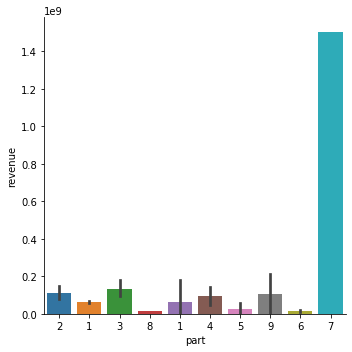

In [471]:
sns.catplot(x='part', y='revenue', data=train, kind='bar');

Nope

In [472]:
train.drop('part', axis=1, inplace=True)

Let's see if my assumption was correct, that sequels (part >= 2) are worse than originals and bring less revenue

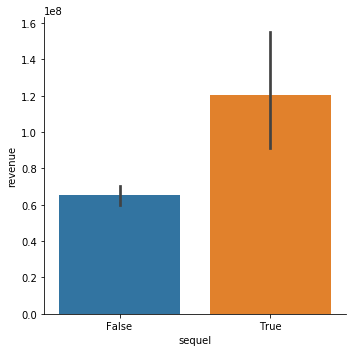

In [473]:
sns.catplot(x='sequel', y='revenue', data=train, kind='bar');

It wasn't, it was exactly the opposite. The reason for this could be, that even if the sequel is worse than part 1, only most famous movies get sequels made, and to see if part 2 is good, people first need to buy a cinema ticket to find out if its good.

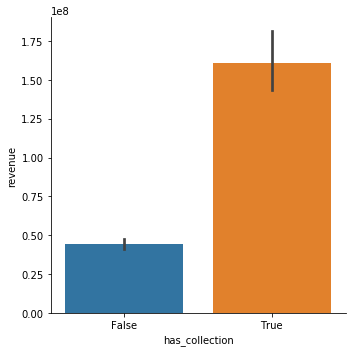

In [474]:
train['has_collection'] = train.belongs_to_collection.notnull();
sns.catplot(x='has_collection', y='revenue', data=train, kind='bar')

This actually looks like a better feature than the one I created myself.

In [475]:
train.drop('sequel', axis=1, inplace=True)

### Budget

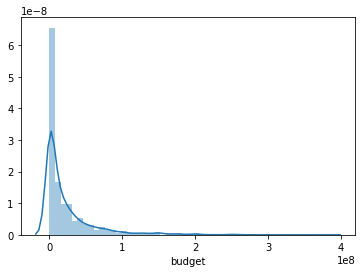

In [476]:
sns.distplot(train.budget);

In [477]:
train[train.dataset == 'test']['budget'][:10]

3000           0
3001       88000
3002           0
3003     6800000
3004     2000000
3005           0
3006           0
3007    30000000
3008    16500000
3009    90000000
Name: budget, dtype: int64

In [478]:
(train.budget == 0).value_counts(dropna=False)

False    5353
True     2000
Name: budget, dtype: int64

We got a lot of missing values, which is a problem, because budget could be one of the strongest predictors of revenue.<br> It's a double whammy, because I have very little data and cannot affort to simply drop these rows.

First, I need to understand if this feature is missing at random, or if there is some logic to it.

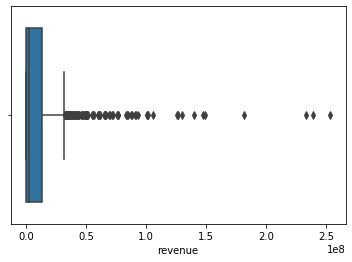

In [479]:
sns.boxplot(train[train.budget == 0]['revenue'])

It looks random.

In [480]:
mask = train.budget == 0
mask1 = train.dataset == 'train'

(train[mask & mask1]['revenue'].mean(), train[~mask & mask1]['revenue'].median())

(12542266.399239544, 29496149.5)

It's 12 mln vs 28 mln. The difference actually is not SO big... but let's make a feature out of it just in case.

In [481]:
train['missing_budget'] = train.budget == 0

In [482]:
bud = train[train.budget > 0]

In [483]:
bud[bud.dataset == 'train'].sort_values('budget')[['budget', 'revenue']][:20]

,budget,revenue
849,1,8500000.00
796,8,33579813.00
2695,10,10000000.00
512,93,2500000.00
469,113,115103979.00
...,...,...
259,24554,140021.00
1356,25000,25000.00
267,27000,3151130.00
746,50000,249905.00


Budgets lower than 2500 seems to be wrong too, in some other unit. I prefer to treat them as 0.

In [484]:
train.loc[ (train.budget < 2500) ]['budget'] = 0

In [485]:
bud = train[train.budget > 2000]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


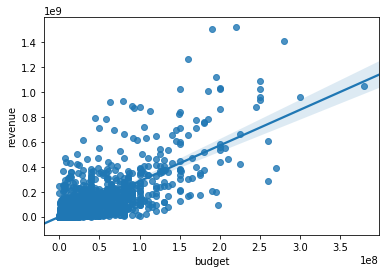

In [486]:
sns.regplot(bud.budget, bud.revenue);

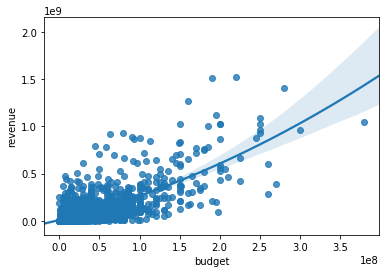

In [487]:
sns.regplot(bud.budget, bud.revenue, order=2);

In [488]:
from scipy.stats import pearsonr
corr, _ = pearsonr(bud[bud.dataset == 'train']['budget'], bud[bud.dataset == 'train']['revenue'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.739


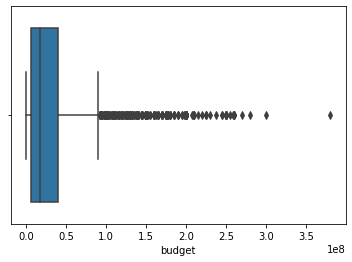

In [489]:
sns.boxplot(bud.budget)

I don't think it's a good idea to just fill these nans with a mean or a median, because the data is really spread out.<br> Given the strong correlation, I will go out on a limb and use ML to guess these missing values. But doing this feels almost like predicting revenue itself.

### Filling in missing budget values using simple regression

In [490]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X=np.array(bud[bud.dataset == 'train']['revenue']).reshape(-1, 1), \
                               y=np.array(bud[bud.dataset == 'train']['budget']).reshape(-1, 1))

In [491]:
budgets_ml = model.predict(np.array(train[(train.budget == 0) & (train.dataset == 'train')]['revenue']).reshape(-1, 1))

In [492]:
#train.loc[(train.budget == 0) & (train.dataset == 'train')]['budget'] = budgets_ml.tolist()

### Not so fast....

The predictions 'work', but are worthless, as the data I used to get them (revenue - my target variable) is present only in the train dataset, of course. So I cannot do the same in the test dataset. To predict budget, I need to use features present in both train and test dataset.

In [493]:
train.corr()[['budget', 'revenue']]

,budget,revenue
id,0.00,0.00
budget,1.00,0.75
popularity,0.34,0.46
runtime,0.22,0.22
revenue,0.75,1.00
is_english,0.19,0.14
has_collection,0.22,0.34
missing_budget,-0.38,-0.24


There is nothing can correlates highly with budget (other than revenue)

### Genre

In [494]:
train.genres[0]

"[{'id': 35, 'name': 'Comedy'}]"

Its a string dictionary because the data was uploaded to kaggle as csv and not as pickle :-/ but we got a fix

In [495]:
import ast
ast.literal_eval(train.genres[0])

[{'id': 35, 'name': 'Comedy'}]

In [496]:
train.genres = train.genres.apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)

In [497]:
sum(train.genres.isnull())

23

In [498]:
# we can live with that

In [499]:
def extract_genres(x):
    if x:
        return [d['name'] for d in x]

train.genres = train.genres.apply(extract_genres)

In [500]:
train.genres[:10]

0                                      [Comedy]
1              [Comedy, Drama, Family, Romance]
2                                       [Drama]
3                             [Thriller, Drama]
4                            [Action, Thriller]
5                [Animation, Adventure, Family]
6                            [Horror, Thriller]
7                                 [Documentary]
8    [Action, Comedy, Music, Family, Adventure]
9                               [Comedy, Music]
Name: genres, dtype: object

We have to turn the list of genres into onehotencoding

In [501]:
from pandas.core.common import flatten
genres = [g for g in set(flatten(train.genres.tolist())) if g]

In [502]:
print(genres)

['Music', 'Horror', 'Science Fiction', 'Action', 'Fantasy', 'History', 'Thriller', 'War', 'Western', 'Crime', 'Mystery', 'TV Movie', 'Foreign', 'Animation', 'Family', 'Romance', 'Drama', 'Adventure', 'Documentary', 'Comedy']


In [503]:
for genre in genres:
    train[genre] = 0

In [504]:
genre_counts ={}

for genre in genres:
    train[genre] = train.genres.apply(lambda x: genre in x if x else 0)
    genre_counts[genre] = sum(train[train[genre] == 1][genre])

In [505]:
genre_counts

{'Music': 265,
 'Horror': 734,
 'Science Fiction': 744,
 'Action': 1726,
 'Fantasy': 627,
 'History': 295,
 'Thriller': 1859,
 'War': 242,
 'Western': 115,
 'Crime': 1079,
 'Mystery': 549,
 'TV Movie': 1,
 'Foreign': 79,
 'Animation': 381,
 'Family': 672,
 'Romance': 1422,
 'Drama': 3653,
 'Adventure': 1113,
 'Documentary': 218,
 'Comedy': 2586}

In [506]:
train[(train.dataset == 'train') & (train.Drama == 1)]['revenue'].std()

94231606.44895054

In [507]:
genre_dict = {}

for genre in genres:
    #print(genre)
    #print(sum(train[genre].fillna(0)), "\n\n")
    genre_dict[genre] = ( train[train[genre] == True]['revenue'].mean(),
                         train[train[genre] == True]['revenue'].median(),
                         train[train[genre] == 1]['revenue'].std(),
                         len(train[train[genre] == True])
                        ) 

In [508]:
gen_df = pd.DataFrame(genre_dict).T

In [509]:
gen_df.columns = ['mean', 'median', 'std', 'count']

In [510]:
gen_df.reset_index(inplace=True)

In [511]:
gen_df

,index,mean,median,std,count
0,Music,43745812.48,14127141.50,75485830.69,265.00
1,Horror,52884767.69,17065170.00,87323889.52,734.00
2,Science Fiction,122367176.31,35109301.50,219234188.27,744.00
3,Action,112408734.28,36893973.00,197619774.08,1726.00
4,Fantasy,148606478.00,49998613.00,237545082.01,627.00
...,...,...,...,...,...
15,Romance,53932900.97,15454665.00,105470533.14,1422.00
16,Drama,46098606.34,11934723.50,94231606.45,3653.00
17,Adventure,177019197.00,60920515.00,256368284.65,1113.00
18,Documentary,4803650.29,278012.00,13532656.33,218.00


According to the law of large numbers, we are more likely to see very low or very high averages when the sample size is small.<br> Something to keep in mind here.

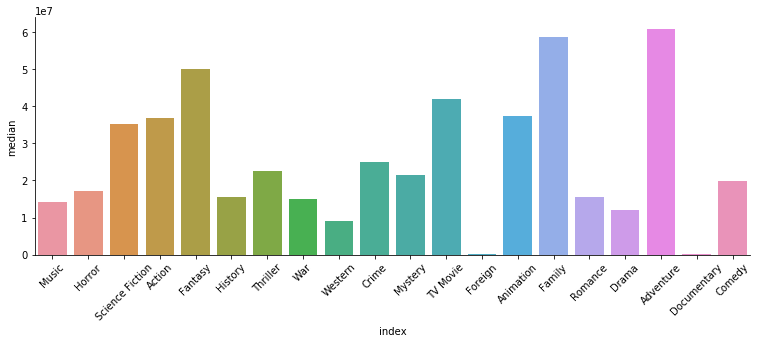

In [512]:
f = sns.catplot(x='index', y= 'median', data=gen_df, kind='bar', ci='sd')
f.fig.set_size_inches(12, 4)
f.set_xticklabels( rotation=45)

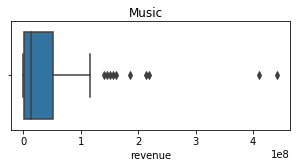

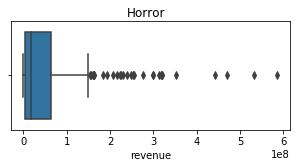

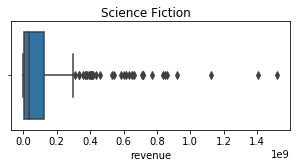

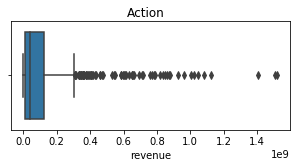

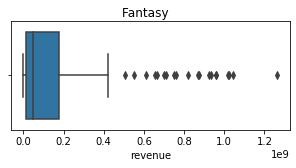

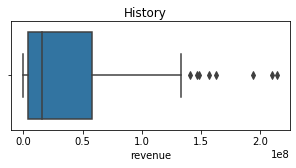

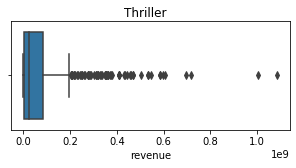

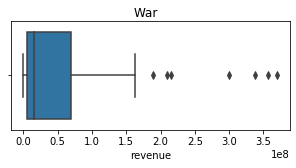

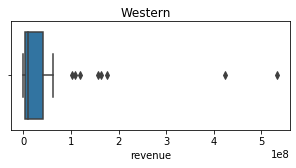

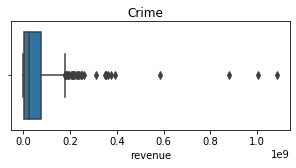

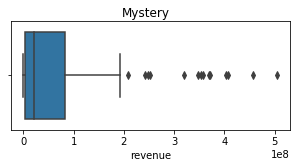

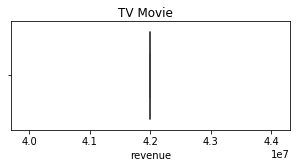

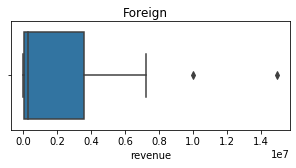

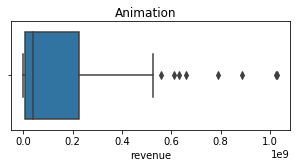

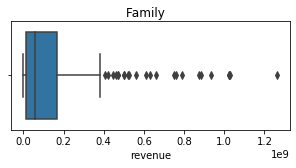

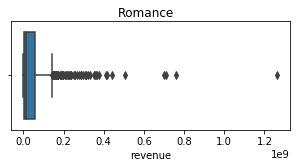

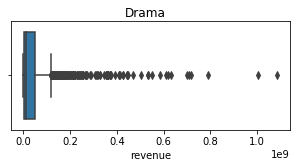

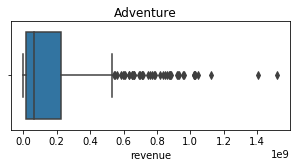

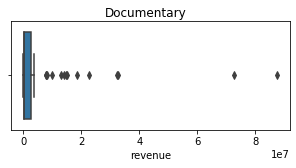

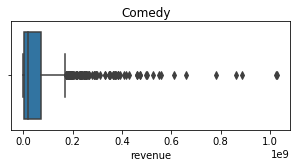

In [513]:
for genre in genres:
    subset = train[ (train.dataset == 'train') & (train[genre] == 1)]
    plt.figure(figsize=(5, 2))
    b = sns.boxplot(subset.revenue)
    b.figure.suptitle(genre)

Also in the genre category, we see big outliers.

### Popularity

I'm not sure what popularity is, given the fact that the aim of this competition is to predict revenue PRIOR TO the release of a movie.

In [514]:
corr, _ = pearsonr(train[train.dataset == 'train']['popularity'], train[train.dataset == 'train']['revenue'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.460


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


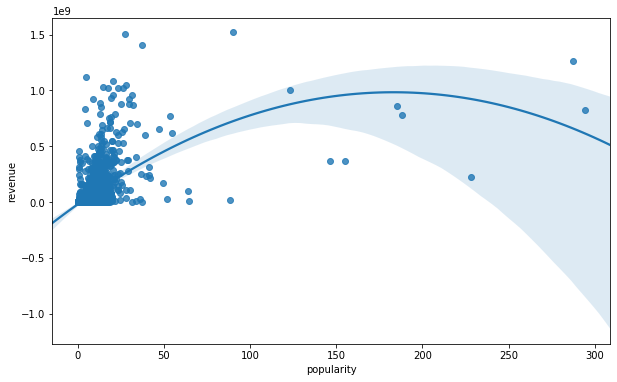

In [515]:
f = sns.regplot(train.popularity, train.revenue, order=2);
f.figure.set_size_inches(10, 6)

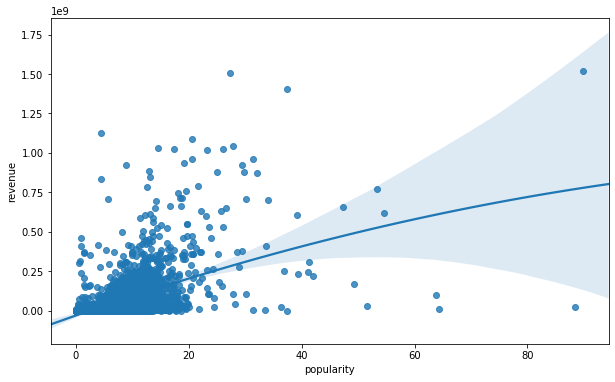

In [516]:
#removing outliers

no_outliers = train[(train.dataset == 'train') & (train.popularity < 100)]
f = sns.regplot(no_outliers.popularity, no_outliers.revenue, order=2);
f.figure.set_size_inches(10, 6)

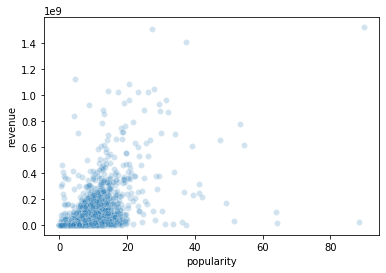

In [517]:
sns.scatterplot(no_outliers.popularity,no_outliers.revenue, alpha=0.2)

In [518]:
corr, _ = pearsonr(no_outliers.popularity, no_outliers.revenue)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.511


Looking at it, I am not convinced it is a good feature, fitting a linear regression line, even of a 2nd order, and even dropping the outliers, still looks forced to me. However, the correlation of 0.5 cannot be ignored, plus we have no better feature to use so far.

### Release Date

This could be relevant, because of the inflation and rising prices across the decades, and the entertainment industry as such has been growing exponentially (more $$$)

In [519]:
train.release_date[:5]

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

In [520]:
train = train[~train.release_date.isnull()]

In [521]:
train['year'] = train.release_date.str[-2:]#.apply(int)
train.year = train.year.apply(lambda x: "20" + x if int(x) < 20 else "19" + x).apply(int)

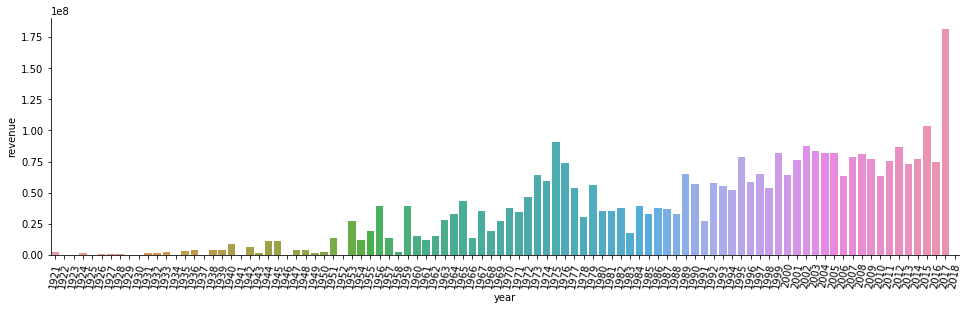

In [522]:
f = sns.catplot(x='year', y= 'revenue', data=train, kind='bar', ci=None)
f.fig.set_size_inches(16, 4)
f.set_xticklabels( rotation=80)

My hunch was correct!

In [523]:
train.corr()['revenue']

id                0.00
budget            0.75
popularity        0.46
runtime           0.22
revenue           1.00
is_english        0.14
has_collection    0.34
missing_budget   -0.24
year              0.14
Name: revenue, dtype: float64

I am surprised why year has no correlation with revenue, if from the graph we can clearly see a relationship.

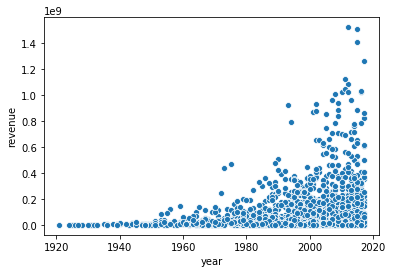

In [524]:
sns.scatterplot(train.year, train.revenue)

I see, even though the averages are clearly correlation, too many low-revenue movies are produced in recent times, which cancels out the correlation.

I am going to bin this feature, even though the literature says that 9 out of 10, you should not bin as you will throw away important trends. In this case, I don't believe there is a relationship between a specific year, and revenue. What is there, however, is a general trend, with rising revenue and times changing (80s, 90s etc). This is unwanted granularity to me. I want to smooth this trend out, by removing outliers, and this can be achieved by binning, taking the median.

In [525]:
train['year_bins'] = pd.cut(train.year, bins=11)

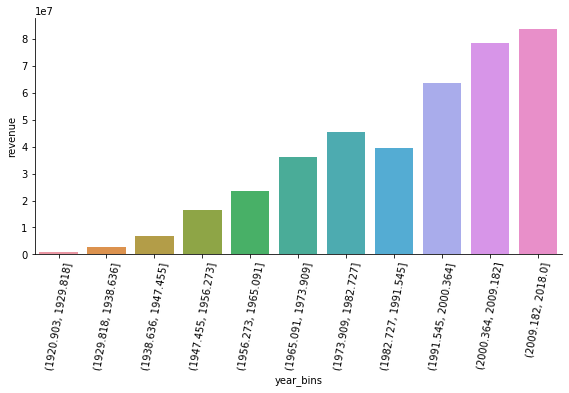

In [526]:
f = sns.catplot(x='year_bins', y= 'revenue', data=train, kind='bar', ci=None, estimator=np.mean)
f.fig.set_size_inches(10, 4)
f.set_xticklabels( rotation=80)

This looks like more meaningful and generizable than without binning. It will also prevent overfitting, in case you have only one or few movies made in e.g. 1974 with super high revenue.

In [527]:
train['year_bins'] = pd.cut(train.year, bins=11, labels=range(11))

This didn't work as I expected, didn't increase the correlation.

In [528]:
train.drop('release_date', inplace=True, axis=1)

### Runtime

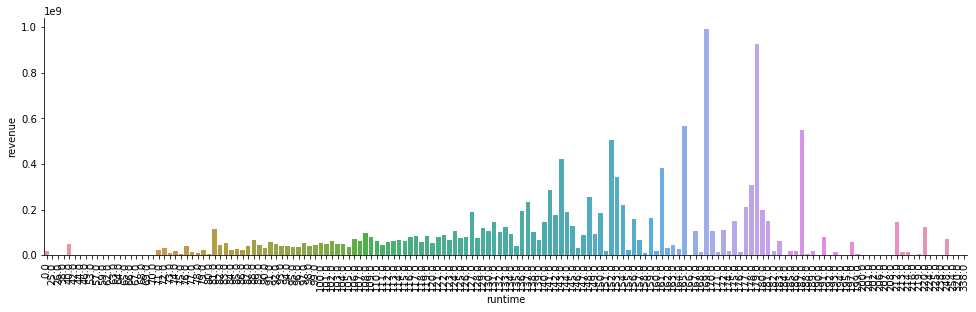

In [529]:
f = sns.catplot(x='runtime', y= 'revenue', data=train, kind='bar', ci=None)
f.fig.set_size_inches(16, 4)
f.set_xticklabels( rotation=90)

The shortest movies never bring much revenue, but with average and long duration, it looks very random. I think that here, just like in the case of production year, smoothing out this feature could result in better generalization of the model.

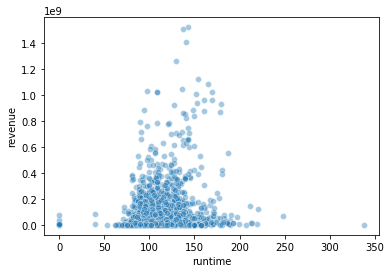

In [530]:
sns.scatterplot(train[train.dataset == 'train']['runtime'], train[train.dataset == 'train']['revenue'], alpha=0.4)

Looking at the scatter plot convinced me not to bin this feature.

In [531]:
len(train[train.runtime.isnull()])

6

In [532]:
train.runtime.fillna(train.runtime.median(), inplace=True)

I would like to somehow quantify how good this feature is. I cannot use correlation, because the relationship runtime-revenue is not linear (even though it's quite strong). In a perfect nonlinear relationship (parabola) the correlation will be 0. But what if i slice the dataset in two - below and above the median, and then calculate two correlations? Could this work? Hmm

In [533]:
short = train[train.runtime < train.runtime.median()] 
long = train[train.runtime > train.runtime.median()] 

corr, _ = pearsonr(short.runtime, short.revenue)
print('Pearsons correlation for short: %.3f' % corr)

corr, _ = pearsonr(long.runtime, long.revenue)
print('Pearsons correlation for long: %.3f' % corr)


Pearsons correlation for short: nan
Pearsons correlation for long: nan


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


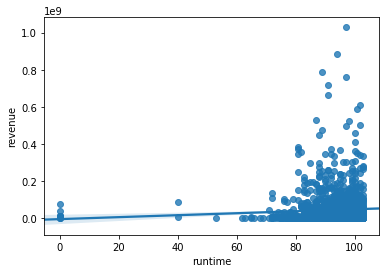

In [534]:
sns.regplot(short.runtime, short.revenue)

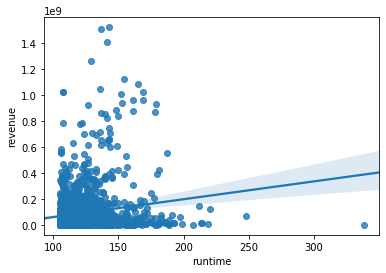

In [535]:
sns.regplot(long.runtime, long.revenue)

Not really. I think I was mislead by the fact that I can see the outliers clearly as dots, but where the color is solid (all dots merge into one), it accounts for most data points.

### Website

I'm not going to scrape the websites, but the missing data might be an indicator of movie's quality.

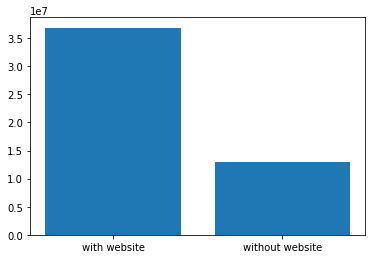

In [536]:
plt.figure()
plt.bar(x=['with website', 'without website'], 
        height=[train[train.homepage.notnull() & (train.dataset == 'train')]['revenue'].median(), 
                train[train.homepage.isnull() & (train.dataset == 'train')]['revenue'].median()]);

In [537]:
train.homepage = train.homepage.notnull()

In [538]:
train.status.value_counts()

Released           7341
Rumored               5
Post Production       5
Name: status, dtype: int64

### Tagline

In [539]:
train.tagline.tolist()[:10]

['The Laws of Space and Time are About to be Violated.',
 "It can take a lifetime to find true love; she's got 30 days!",
 'The road to greatness can take you to the edge.',
 nan,
 nan,
 nan,
 "Fear The Demon That Doesn't Fear God",
 'Different channels. Different truths.',
 'Set sail for Muppet mayhem!',
 'Back together for the first time, again.']

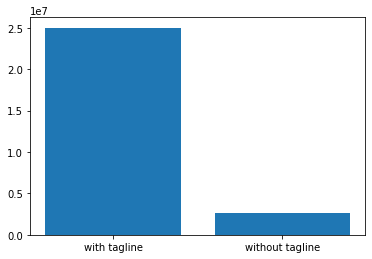

In [540]:
plt.bar(x=['with tagline', 'without tagline'], 
        height=[train[train.tagline.notnull()]['revenue'].median(), 
                train[train.tagline.isnull()]['revenue'].median()]);

In [541]:
train['has_tagline'] = train.tagline.notnull()

In [542]:
sum(train.tagline.isnull())

1440

In [543]:
train['tagline_len'] = train.tagline.apply(lambda x: len(x) if not pd.isna(x) else 0)

In [544]:
train['tagline_len_bins'] = pd.cut(train.tagline_len, bins=30)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


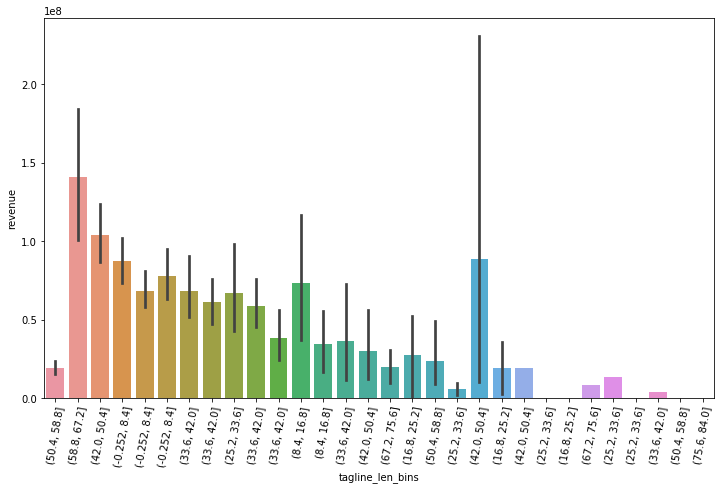

In [545]:
f = sns.barplot(train.loc[train.dataset == 'train', 'tagline_len_bins'], 
            train.loc[train.dataset == 'train', 'revenue'])

f.figure.set_size_inches(12, 7)

f.set_xticklabels(train.loc[train.dataset == 'train', 'tagline_len_bins'].tolist(), rotation=80,);

Looks good to me!<br> 'Free' feature :-)

### Production company

We already know that english language movies have higher revenue. Production companies could let us further differentiate within english movies.

In [546]:
sum(train.production_companies.isnull())

403

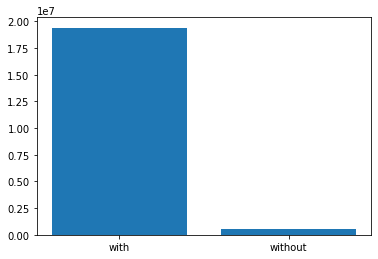

In [547]:
plt.bar(x=['with', 'without'], 
        height=[train[train.production_companies.notnull()]['revenue'].median(), 
                train[train.production_companies.isnull()]['revenue'].median()]);

It's a good predictor, but the categories are imbalanced.

In [548]:
train['has_production'] = train.production_companies.notnull()

In [549]:
train.production_companies = train.production_companies.apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)

The first position in the dictionary seems to be the main production company, so I will take only that one.

In [550]:
train.production_companies = train.production_companies.str[0]

In [551]:
train.production_companies

0                 {'name': 'Paramount Pictures', 'id': 4}
1               {'name': 'Walt Disney Pictures', 'id': 2}
2                      {'name': 'Bold Films', 'id': 2266}
3                                                    None
4                                                    None
                              ...                        
7393              {'name': 'Intermedia Films', 'id': 763}
7394              {'name': 'Paramount Pictures', 'id': 4}
7395    {'name': 'Twentieth Century Fox Film Corporati...
7396        {'name': 'Northern Lights Films', 'id': 8714}
7397       {'name': 'Pathé Consortium Cinéma', 'id': 220}
Name: production_companies, Length: 7352, dtype: object

In [552]:
train['prod_id'] = train.production_companies.apply(lambda x: x['id'] if pd.notnull(x) else None)
train['prod_name'] = train.production_companies.apply(lambda x: x['name'] if pd.notnull(x) else None)

In [553]:
train[train.dataset == 'train'].prod_name.value_counts()[:10]

Universal Pictures                        166
Paramount Pictures                        155
Twentieth Century Fox Film Corporation    122
Columbia Pictures                          90
New Line Cinema                            69
Warner Bros.                               69
Walt Disney Pictures                       62
Columbia Pictures Corporation              44
TriStar Pictures                           43
United Artists                             41
Name: prod_name, dtype: int64

Production company is an example of categorical data with high cardinality. Normally, I would use onehotencoding, but in this case, it will slow down the model (too many features), given many categories with only 1 member. Moreover, it can be prone to overfitting. <br><br>
I can solve this issue by:
1. Adding a new column, 'company_avg' which is the average of the revenue within the company group.
2. Keep only biggest companies, and encode others as 'miscellaneous'
3. (trying hard to be creative) Turning this feature into an ordinal feature, 1 - company with lowest revenue mean, N - company with highest revenue mean.

<br>
The problem option 1 poses, is that I will have to create this column in the test data too, with values from the train data. But given high cardinality, it will happen that many production companies in the test data are not in the train data, so i have no value to input there.

In [554]:
x = set(train[train.dataset == 'train']['prod_name'])
y = set(train[train.dataset == 'test']['prod_name'])

In [555]:
len(y - x)

939

In [556]:
sum(train.prod_name.value_counts() < 3)

1632

In [557]:
agg = train.loc[train.dataset == 'train'][['prod_name', 'revenue']].groupby('prod_name').agg({'prod_name' : 'size', 
                                                                'revenue' : ['mean', list ],
                                                               })

In [558]:
agg

prod_name      revenue                            
                           size         mean                        list
prod_name                                                               
10th Hole Productions         1    123820.00                  [123820.0]
120dB Films                   1   1133031.00                 [1133031.0]
1492 Pictures                 2 525633616.50  [174578751.0, 876688482.0]
1818                          1  12232628.00                [12232628.0]
21 Laps Entertainment         1   3305592.00                 [3305592.0]
...                         ...          ...                         ...
Вольга                        1   2228115.00                 [2228115.0]
Леополис                      1  10198357.00                [10198357.0]
Роскинопрокат                 1    234748.00                  [234748.0]
СТВ                           1    243000.00                  [243000.0]
Фокс                          1  55635037.00                [55635037.0]

[1047 rows x 3 columns]

In [559]:
len(agg.index)

1047

Do bigger companies (bigger movie count), have higher average revenue? If so, this solves our problem of not all companies in test set being present in train set, they would just get the count = 1

In [560]:
revenue_by_size = agg.groupby( ('prod_name', 'size')).agg({ ('revenue', 'list') : list})

In [561]:
# I'm doing these aggregations into a list to avoid working with a mean of a mean.

In [562]:
revenue_by_size

,revenue
,list
"(prod_name, size)",
1,"[[123820.0], [1133031.0], [12232628.0], [33055..."
2,"[[174578751.0, 876688482.0], [13060843.0, 2156..."
3,"[[754249.0, 6860853.0, 123384128.0], [2287714...."
4,"[[22678555.0, 15400000.0, 89162162.0, 75993061..."
5,"[[6673422.0, 3148182.0, 27635305.0, 54600000.0..."
...,...
69,"[[136159423.0, 258022233.0, 25482931.0, 323920..."
90,"[[46069568.0, 106260000.0, 5731103.0, 87528173..."


In [563]:
revenue_by_size['unique_companies'] = revenue_by_size[ ('revenue', 'list')].apply(len)

In [564]:
revenue_by_size[ ('revenue', 'list')] = revenue_by_size[ ('revenue', 'list')].apply(lambda x: list(flatten(x)))

In [565]:
revenue_by_size['avg_rev'] = revenue_by_size[ ('revenue', 'list')].apply(lambda x: np.mean(x))

In [566]:
revenue_by_size

,revenue,unique_companies,avg_rev
,list,,
"(prod_name, size)",,,
1,"[123820.0, 1133031.0, 12232628.0, 3305592.0, 1...",775,23035348.61
2,"[174578751.0, 876688482.0, 13060843.0, 2156785...",126,41410307.74
3,"[754249.0, 6860853.0, 123384128.0, 2287714.0, ...",47,49230052.46
4,"[22678555.0, 15400000.0, 89162162.0, 75993061....",26,61701433.60
5,"[6673422.0, 3148182.0, 27635305.0, 54600000.0,...",14,50874655.09
...,...,...,...
69,"[136159423.0, 258022233.0, 25482931.0, 3239204...",2,88541850.36
90,"[46069568.0, 106260000.0, 5731103.0, 87528173....",1,117488243.40


In [567]:
list(zip(revenue_by_size.index, revenue_by_size['unique_companies'].tolist()))

[(1, 775),
 (2, 126),
 (3, 47),
 (4, 26),
 (5, 14),
 (6, 13),
 (7, 3),
 (8, 8),
 (9, 2),
 (10, 5),
 (11, 2),
 (12, 3),
 (13, 2),
 (18, 2),
 (21, 2),
 (24, 1),
 (27, 1),
 (28, 2),
 (29, 1),
 (38, 1),
 (39, 1),
 (41, 1),
 (43, 1),
 (44, 1),
 (62, 1),
 (69, 2),
 (90, 1),
 (122, 1),
 (155, 1),
 (166, 1)]

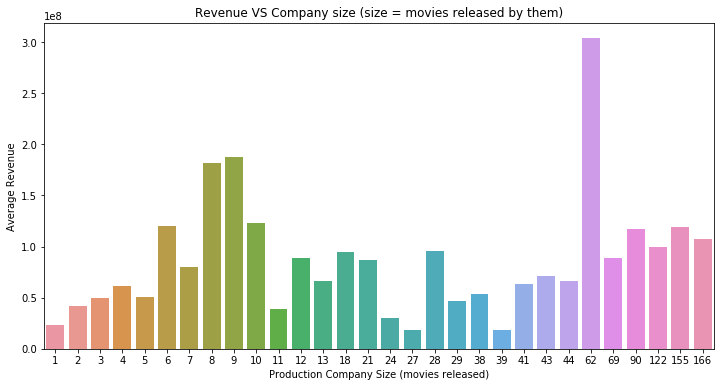

In [568]:
f = sns.barplot(revenue_by_size.index, revenue_by_size.avg_rev.tolist())
f.figure.set_size_inches(12, 6)

f.set_xlabel("Production Company Size (movies released)")
f.set_ylabel("Average Revenue")
f.set_title("Revenue VS Company size (size = movies released by them)");

I think this could be a meaningful feature, we see that the revenue rises in the range 1-9, where most datapoint per group are available. Apart from the data, it also makes sense that if a specific company releases many movies, those movies must be more-less successful, otherwise the company would go bankrupt. The graph gets erratic for bigger companies, because there are less data points per group.

In [569]:
sizes = train.groupby('prod_name').size()

In [570]:
sizes

prod_name
100 Bares                2
10th Hole Productions    1
120dB Films              2
1492 Pictures            4
1818                     1
                        ..
Леополис                 1
Наше Кино                1
Роскинопрокат            1
СТВ                      1
Фокс                     1
Length: 1986, dtype: int64

In [571]:
train = pd.merge(train, pd.DataFrame(sizes), on='prod_name')
train.rename({0 : 'comp_size'}, axis=1, inplace=True)

In [572]:
corr, _ = pearsonr(train[train.dataset == 'train']['comp_size'], train[train.dataset == 'train']['revenue'] )
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.184


Unfortunately still very low.

### Famous people

Famous actors start in famous movies, which bring in lots of money. But how can we quantify 'famous'?
<br> One way I can think of, is scraping google and harvesting the number search results per actor.<br>
Another way is judging popularity by number of movies they star in.

In [573]:
train['cast'] = train.cast.apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)

In [574]:
import ast
from collections import Counter

train['actor_1'] = train.cast.str[0].apply(lambda x: x.get('name', None) if type(x) is dict else None)
train['actor_2'] = train.cast.str[1].apply(lambda x: x.get('name', None) if type(x) is dict else None)

In [575]:
actors1 = train.actor_1.tolist()
actors2 = train.actor_2.tolist()

actors1.extend(actors2)

actors1 = [a for a in actors1 if not pd.isna(a)]
actor_count = Counter(actors1)

In [576]:
actor_count.most_common()[:20]

[('Robert De Niro', 50),
 ('Nicolas Cage', 46),
 ('Bruce Willis', 43),
 ('Sylvester Stallone', 40),
 ('Tom Hanks', 39),
 ('Denzel Washington', 37),
 ('Clint Eastwood', 37),
 ('Johnny Depp', 36),
 ('Matt Damon', 34),
 ('Tom Cruise', 33),
 ('Morgan Freeman', 33),
 ('Robin Williams', 33),
 ('Mel Gibson', 32),
 ('John Travolta', 32),
 ('Eddie Murphy', 32),
 ('Harrison Ford', 31),
 ('Samuel L. Jackson', 31),
 ('Liam Neeson', 31),
 ('Brad Pitt', 30),
 ('Mark Wahlberg', 30)]

I will take the product of popularity of two main actors.

In [577]:
train['actor_popularity'] = np.array(train.actor_1.map(actor_count)) * np.array(train.actor_2.map(actor_count))

In [578]:
train.actor_popularity.replace(0, train.actor_popularity.median(), inplace=True)

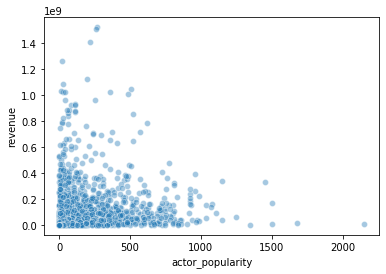

In [579]:
sns.scatterplot(train.actor_popularity, train.revenue, alpha=0.4)

In [580]:
corr, _ = pearsonr(train[train.dataset == 'train'].actor_popularity, train[train.dataset == 'train'].revenue)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.194


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


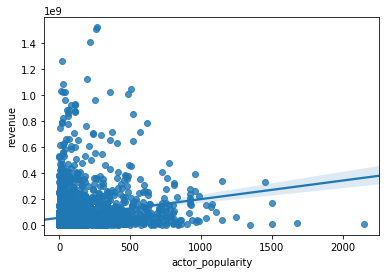

In [581]:
sns.regplot(train.actor_popularity, train.revenue)

In the above plot we see some outliers. What if we could spread out the smaller actor_popularity values more apart? We use take the log of that value

In [582]:
pd.set_option('display.max_rows', 20)
train[(train.dataset == 'train') & (train.actor_popularity > 1000)][['actor_1', 'actor_2', 'actor_popularity', 'original_title', 'year', 'budget', 'revenue']]

,actor_1,actor_2,actor_popularity,original_title,year,budget,revenue
60,Robert De Niro,Meryl Streep,1500,Falling in Love,1984,0,11129057.00
61,Denzel Washington,Meryl Streep,1110,The Manchurian Candidate,2004,80000000,96105964.00
965,Ben Stiller,Robert De Niro,1450,Meet the Parents,2000,55000000,330444045.00
1108,Dustin Hoffman,Robert De Niro,1250,Wag the Dog,1997,15000000,64256513.00
1379,Bruce Willis,Richard Gere,1075,The Jackal,1997,60000000,159330280.00
1944,Tom Hanks,Bruce Willis,1677,The Bonfire of the Vanities,1990,47000000,15691192.00
2202,Clint Eastwood,Gene Hackman,1036,Absolute Power,1997,50000000,50068310.00
2419,Sean Connery,Nicolas Cage,1150,The Rock,1996,75000000,335062621.00
2424,Denzel Washington,Gene Hackman,1036,Crimson Tide,1995,53000000,157387195.00
3772,Robert De Niro,Brad Pitt,1500,Sleepers,1996,44000000,165615285.00


In [583]:
import math

train['actor_popularity_log'] = 0
train.loc[(train.actor_popularity > 0), 'actor_popularity_log'] = \
train.loc[train.actor_popularity != 0, 'actor_popularity'].apply(lambda x: math.log(x))

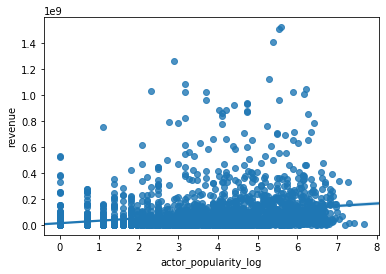

In [584]:
sns.regplot(train.actor_popularity_log, train.revenue)

In [585]:
corr, _ = pearsonr(train[train.dataset == 'train'].actor_popularity_log, train[train.dataset == 'train'].revenue)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.269


# Filling in missing Budget values

### Brief recap:
The biggest predictor of revenue is budget. But budget has a lot of missing values. I must fill in these missing values, as I must use budget as one of my features (it's the best one). I cannot use revenue to do that, as revenue is our dependent variable, and it's missing in the test dataset (obviously). So I need to build a model with features other than revenue, that can predict budget, so that I can fill in these NA.

## Normalization or Standardization?

Those are the two main techniques for feature scaling. Standardization handles outliers better.

![title](img/minmax.png)
![title](img/standard.png)

In normalization, the x axis is squeezed onto a small area (0-0.4) while the y axis uses the full range (0-1).<br>
https://www.codecademy.com/articles/normalization

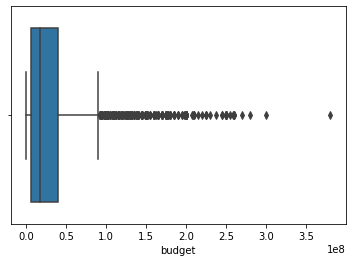

In [586]:
sns.boxplot(train[train.budget != 0]['budget'])

We have a lot of outliers (very high) budgets in our most important feature, so I will choose standardization.

In [587]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [588]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'dataset', 'is_english', 'has_collection',
       'missing_budget', 'Music', 'Horror', 'Science Fiction', 'Action',
       'Fantasy', 'History', 'Thriller', 'War', 'Western', 'Crime', 'Mystery',
       'TV Movie', 'Foreign', 'Animation', 'Family', 'Romance', 'Drama',
       'Adventure', 'Documentary', 'Comedy', 'year', 'year_bins',
       'has_tagline', 'tagline_len', 'tagline_len_bins', 'has_production',
       'prod_id', 'prod_name', 'comp_size', 'actor_1', 'actor_2',
       'actor_popularity', 'actor_popularity_log'],
      dtype='object')

In [601]:
df = train[[ 'budget', 'runtime', 'year_bins', 'missing_budget',
                'has_tagline', 'has_production', 'actor_popularity_log',
               'is_english', 'has_collection', 'comp_size',
                'tagline_len', 'popularity', 
            
               'Fantasy', 'Animation', 'Thriller', 'Mystery',
               'Comedy', 'Action', 'Foreign', 'History', 'Family', 'Horror',
               'TV Movie', 'War', 'Western', 'Romance', 'Music', 'Science Fiction',
               'Documentary', 'Crime', 'Drama', 'Adventure']]

df = df[df.budget != 0]
y = df['budget']
df.drop('budget', axis=1, inplace=True)

In [602]:
# BECAUSE WE HAVE VERY LITTLE DATA, I WILL USE CROSS VALIDATION TO USE IT IN SMARTEST WAY AND FIND THE PARAMS

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(np.array(X_train))
X_test = sc_X.transform(np.array(X_test))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## What model to choose?

Looking at the data, the relationships look very complex. There are many outliers, in almost every feature. Also, the relationships are often non linear (runtime, popularity, actor_popularity). This makes me think a non-parametric model (like knn) might perform better than linear regression.

# KNN

We can use euclidean distance here because we standardized out features. One thing about knn is that it doesn't do feature selection, like lasso. So the features we feed into it, must be well thought out.

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor()

param_grid = {'n_neighbors': np.arange(1, 25), 'weights': ['uniform', 'distance'],}

# GridSearchCV, by convention, always tries to maximize its score so loss functions like MSE have to be negated
knn_gscv = GridSearchCV(knn, param_grid, cv=5,scoring='neg_mean_squared_error')
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_

{'n_neighbors': 19, 'weights': 'distance'}

In [150]:
print(f"{int(math.sqrt(abs(knn_gscv.best_score_))):,d}")

27,736,482


In [612]:
best_knn = KNeighborsRegressor(n_neighbors=22, weights='distance')
best_knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=22, p=2,
          weights='distance')

In [613]:
from sklearn.metrics import mean_squared_error
pred = best_knn.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))


In [614]:
print(f"{int(error):,d}")

28,496,019


In [615]:
test_errors = {'knn' : error}

# Decision Trees

In [155]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

param_grid = {'max_depth': np.arange(1, 100), }

tree_gscv = GridSearchCV(tree, param_grid, cv=5,scoring='neg_mean_squared_error')
tree_gscv.fit(X_train, y_train)
tree_gscv.best_params_

{'max_depth': 6}

In [156]:
print(f"{int(math.sqrt(abs(tree_gscv.best_score_))):,d}")

31,116,235


In [616]:
best_tree = DecisionTreeRegressor(max_depth=5)

best_tree.fit(X_train, y_train)
pred = best_tree.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [617]:
print(f"{int(error):,d}")

28,980,165


In [618]:
test_errors['tree'] = error

# Random Forest

They're an example of BAGGING, where a lot of weak models are combined to create a strong model. Those models are not dependent on each other (paralell). Random forests build many trees, and use a majority vote (or a mean of vote) to predict the dependent variable. When building each tree, a random set of rows and features is selected. This makes this model very robust to overfitting.

In [160]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()

param_grid = {'n_estimators': [int(x) for x in np.linspace(3, 300, num=10) ]}

forest_gscv = GridSearchCV(forest, param_grid, cv=5,scoring='neg_mean_squared_error')
forest_gscv.fit(X_train, y_train)
forest_gscv.best_params_

{'n_estimators': 168}

In [161]:
print(f"{int(math.sqrt(abs(forest_gscv.best_score_))):,d}")

25,248,490


In [627]:
best_forest = RandomForestRegressor(n_estimators = 201)

best_forest.fit(X_train, y_train)
pred = best_forest.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

print(f"{int(error):,d}")

23,805,099


In [628]:
test_errors['forest'] = error

# Linear Regression

In [164]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

params = {'alpha' : np.linspace(0.1, 5000000, num=1000)}

lasso = linear_model.Lasso(tol=0.1)
lasso_grid = GridSearchCV(lasso, params, cv=5, scoring='neg_mean_squared_error')

lasso_grid.fit(X_train, y_train);

In [165]:
lasso_grid.best_params_['alpha']

125125.22262262262

In [166]:
print(f"{int(math.sqrt(abs(lasso_grid.best_score_))):,d}")

29,206,118


In [629]:
best_lasso = linear_model.Lasso(alpha=lasso_grid.best_params_['alpha'])

best_lasso.fit(X_train, y_train)
pred = best_lasso.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [630]:
print(f"{int(error):,d}")

30,084,759


In [631]:
test_errors['lasso'] = error

# SVM

### Trying different degrees for linear kernel

In [170]:
from sklearn.svm import SVC

params = {'degree' : [1, 2, 3]}

svm = SVC(kernel='poly', gamma='scale')
svm_grid = GridSearchCV(svm, params, cv=5, scoring='neg_mean_squared_error')

svm_grid.fit(X_train, y_train);
svm_grid.best_params_['degree']

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1

In [171]:
print(f"{int(math.sqrt(abs(svm_grid.best_score_))):,d}")

31,718,230


### Trying different kernels

In [172]:
from sklearn.svm import SVC

params = {'kernel' : ['rbf', 'sigmoid']}

svm = SVC(gamma='scale')
svm_grid = GridSearchCV(svm, params, cv=5, scoring='neg_mean_squared_error')

svm_grid.fit(X_train, y_train);
svm_grid.best_params_['kernel']

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


'rbf'

In [173]:
print(f"{int(math.sqrt(abs(svm_grid.best_score_))):,d}")

33,228,115


In [632]:
best_svm = SVC(gamma='scale', kernel='rbf')

best_svm.fit(X_train, y_train)
pred = best_svm.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [633]:
error

33760075.78132308

In [634]:
test_errors['svm'] = error

### Adaboost

Boosting involves creating many weak models, that are dependent on each other (unlike bagging). For every model, the weights are increased on the data points where the previous model got the answers wrong. At the end, every model gets its own importance weight, depending on its accuracy. Then the voting happens.

In [437]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                              random_state=0)
params = {'n_estimators': range(2, 100)}
ada_grid = GridSearchCV(ada, params, cv=5, scoring='neg_mean_squared_error')
ada_grid.fit(X_train, y_train);
ada_grid.best_params_['n_estimators']

78

In [430]:
ada_grid.best_score_

-631523433328032.5

In [431]:
print(f"{int(math.sqrt(abs(ada_grid.best_score_))):,d}")

25,130,129


In [635]:
best_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                              random_state=0, n_estimators=78)

best_ada.fit(X_train, y_train)
pred = best_ada.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [636]:
error

23516444.513882678

In [637]:
test_errors['ada'] = error

In [638]:
pd.Series(test_errors).sort_values()

ada      23516444.51
forest   23805099.57
knn      28496019.61
tree     28980165.08
lasso    30084759.66
svm      33760075.78
dtype: float64

In [639]:
df = train[['id', 'dataset', 'budget', 'runtime', 'year_bins', 'missing_budget',
                'has_tagline', 'has_production', 'actor_popularity_log',
               'is_english', 'has_collection', 'comp_size',
                'tagline_len', 'popularity', 
            
               'Fantasy', 'Animation', 'Thriller', 'Mystery',
               'Comedy', 'Action', 'Foreign', 'History', 'Family', 'Horror',
               'TV Movie', 'War', 'Western', 'Romance', 'Music', 'Science Fiction',
               'Documentary', 'Crime', 'Drama', 'Adventure']]



In [640]:
with_budget = df[~df['missing_budget']]
no_budget = df[df['missing_budget']]

In [641]:
dataset = no_budget.dataset
ids = no_budget['id']

no_budget.drop(['dataset', 'id', 'budget'], axis=1, inplace=True)

sc_X = StandardScaler()
X_test = sc_X.fit_transform(np.array(no_budget))
preds = best_ada.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [642]:
no_budget['budget'] = list(preds)
no_budget['id'] = list(ids)
no_budget['dataset'] = list(dataset)

In [647]:
sum(with_budget.append(no_budget)['budget'] == 0)

0

In [648]:
train_ = with_budget.append(no_budget)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Predicting revenue (at last!)

Now have a new feature - budget, that's filled in for all the rows. If I was lazy, to predict the revenue, I would just use the best model from the previous task (budget), however, this would be a mistake. Now we have a new feature, that's in extreme linear relationship to revenue. So now actually the linear models might perform better than before.